In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

2025-07-16 15:17:31.810473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 15:17:31.819613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752671851.829802 3269837 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752671851.832744 3269837 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752671851.840738 3269837 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

In [4]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
n_filters_conv_1 = 10 
filter_size_conv_1 = 5
n_filters_conv_2 = 10
filter_size_conv_2 = 5
n_neurons_dense_1 = 50
n_neurons_dense_2 = 10

n_epochs = 20
batch_size = 256

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (filter_size_conv_1, filter_size_conv_1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (filter_size_conv_2, filter_size_conv_2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax', dtype='float32'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/home/maciej_stanislawski/miniconda3/envs/huretex/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752671853.926493 3269837 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43475 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 10)     │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 10)     │         2,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       200,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,330 (794.26 KB)

 Trainable params: 203,330 (794.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
for layer in model.layers:
    print(f"{layer.name}: {layer.dtype}")

conv2d: float32
conv2d_1: float32
flatten: float32
dense: float32
dense_1: float32


In [9]:
for layer in model.layers:
    for weight in layer.weights:
        print(f"{weight.name} - dtype: {weight.dtype}")


kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32


In [10]:
print(x_train.dtype)

float32


In [11]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=2)

Epoch 1/20


I0000 00:00:1752671855.072049 3271295 service.cc:152] XLA service 0x7fd4f00093b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752671855.072092 3271295 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-07-16 15:17:35.121779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752671855.212887 3271295 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1752671858.804274 3271295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-16 15:17:40.679329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_363', 8 bytes spill stores, 8 bytes spill loads

2025-07-16 15:17:43.944576: I external/local_xla/xla

188/188 - 10s - 55ms/step - accuracy: 0.9021 - loss: 0.3220 - val_accuracy: 0.9670 - val_loss: 0.1134
Epoch 2/20
188/188 - 1s - 7ms/step - accuracy: 0.9744 - loss: 0.0881 - val_accuracy: 0.9747 - val_loss: 0.0844
Epoch 3/20
188/188 - 1s - 7ms/step - accuracy: 0.9826 - loss: 0.0582 - val_accuracy: 0.9818 - val_loss: 0.0633
Epoch 4/20
188/188 - 1s - 7ms/step - accuracy: 0.9868 - loss: 0.0442 - val_accuracy: 0.9800 - val_loss: 0.0640
Epoch 5/20
188/188 - 1s - 7ms/step - accuracy: 0.9898 - loss: 0.0339 - val_accuracy: 0.9853 - val_loss: 0.0477
Epoch 6/20
188/188 - 1s - 7ms/step - accuracy: 0.9918 - loss: 0.0267 - val_accuracy: 0.9860 - val_loss: 0.0483
Epoch 7/20
188/188 - 1s - 7ms/step - accuracy: 0.9931 - loss: 0.0219 - val_accuracy: 0.9883 - val_loss: 0.0429
Epoch 8/20
188/188 - 1s - 7ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9880 - val_loss: 0.0441
Epoch 9/20
188/188 - 1s - 7ms/step - accuracy: 0.9959 - loss: 0.0133 - val_accuracy: 0.9878 - val_loss: 0.0483
Epoch 10/2

In [12]:
layer_outputs = [layer.output for layer in model.layers]
print("Input: ", model.layers[0].input.shape)
print("Output: ", layer_outputs)
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

Input:  (None, 28, 28, 1)
Output:  [<KerasTensor shape=(None, 24, 24, 10), dtype=float32, sparse=False, name=keras_tensor_1>, <KerasTensor shape=(None, 20, 20, 10), dtype=float32, sparse=False, name=keras_tensor_3>, <KerasTensor shape=(None, 4000), dtype=float32, sparse=False, name=keras_tensor_6>, <KerasTensor shape=(None, 50), dtype=float32, sparse=False, name=keras_tensor_10>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_15>]


In [13]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 780us/step


In [14]:
artifact_clusters = pd.DataFrame()
print(artifact_clusters)

Empty DataFrame
Columns: []
Index: []


## Parallelized

In [15]:
import multiprocessing as mp

print(mp.cpu_count())

640


In [16]:
from itertools import product

a = (0, 1) # number of conv layers
b = range(max(n_filters_conv_2, n_filters_conv_1)) # max nr of filter in conv layers

kombinacje = list(product(a, b))
print(kombinacje)


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9)]


### First method

In [17]:
from joblib import Parallel, delayed
from sklearn.cluster import AgglomerativeClustering

def process_filter(l, f):
    print(f'filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)
    print(f, activations_f[0, :3])
    return l, f, ac_f.labels_

results = Parallel(n_jobs=-1)(delayed(process_filter)(l, f) for l, f in kombinacje)

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels


filter: 7
filter: 0
filter: 5
filter: 9
filter: 8
filter: 6
filter: 8filter: 9

filter: 4
filter: 1
filter: 2
filter: 7
filter: 2
filter: 4
filter: 3
filter: 0
filter: 5
filter: 1
filter: 6
filter: 3
9 [0. 0. 0.]
1 [0. 0. 0.]
6 [0. 0. 0.]
4 [0.02348077 0.02348077 0.02348077]
2 [0. 0. 0.]
8 [0.01789317 0.01789317 0.01789317]
5 [0. 0. 0.]
3 [0.02650341 0.02650341 0.02650341]
3 [0. 0. 0.]
8 [0. 0. 0.]
7 [0. 0. 0.]
5 [0.00970198 0.00970198 0.00970198]
6 [0.00839978 0.00839978 0.00839978]
4 [0.03317793 0.03317793 0.03317793]
0 [0. 0. 0.]
9 [0.04304359 0.04304359 0.04304359]
7 [0.01800979 0.01800979 0.01800979]
0 [0.06447859 0.06447859 0.06447859]
2 [0. 0. 0.]
1 [0.08653675 0.08653675 0.08653675]


### Second method

In [18]:
from multiprocessing import Pool, cpu_count

def process_filter(lf):
    l, f = lf
    print(f'layer: {l} filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)
    print(f, activations_f[0, :3])
    return l, f, ac_f.labels_

with Pool(processes=mp.cpu_count()) as pool:
    results = pool.map(process_filter, [(l, f) for l, f in kombinacje])

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels

layer: 0 filter: 2layer: 1 filter: 1layer: 0 filter: 0layer: 1 filter: 0layer: 0 filter: 1layer: 0 filter: 3layer: 1 filter: 2layer: 1 filter: 3







0 [0. 0. 0.]
3 [0. 0. 0.]
2 [0.0090723 0.0090723 0.0090723]
1 [0. 0. 0.]
0 [0.00544083 0.00544083 0.00544083]
3 [0.02403934 0.02403934 0.02403934]
2 [0.08541086 0.08541086 0.08541086]
1 [0.08001234 0.08001234 0.08001234]


### Using fastcluster library

In [17]:
from joblib import Parallel, delayed
import fastcluster
import scipy.cluster.hierarchy as sch

def process_filter(l, f):
    print(f'filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    Z = fastcluster.linkage(activations_f, method='ward')
    ac_f = sch.fcluster(Z, t=10, criterion='maxclust')
    print(f, activations_f[0, :3])
    return l, f, ac_f

results = Parallel(n_jobs=-1)(delayed(process_filter)(l, f) for l, f in kombinacje)

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels


filter: 3
filter: 3
filter: 1
filter: 2
filter: 1
filter: 0
filter: 0
filter: 2
2 [0. 0. 0.]
1 [0.01380006 0.01132164 0.        ]
0 [0. 0. 0.]
3 [0. 0. 0.]
0 [0.12158418 0.12158418 0.12158418]
2 [0.08205345 0.08205345 0.08205345]
3 [0.13018328 0.13018328 0.13018328]
1 [0. 0. 0.]


In [48]:
from multiprocessing import Pool, cpu_count

def process_filter(lf):
    l, f = lf
    print(f'layer: {l} filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    Z = fastcluster.linkage(activations_f, method='ward')
    ac_f = sch.fcluster(Z, t=10, criterion='maxclust')
    print(f, activations_f[0, :3])
    return l, f, ac_f

with Pool(processes=mp.cpu_count()) as pool:
    results = pool.map(process_filter, [(l, f) for l, f in kombinacje])

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels

layer: 0 filter: 3layer: 0 filter: 1layer: 0 filter: 0layer: 0 filter: 2layer: 1 filter: 0layer: 1 filter: 1layer: 1 filter: 2layer: 1 filter: 3







2 [0. 0. 0.]
0 [0. 0. 0.]
1 [0.01380006 0.01132164 0.        ]
3 [0. 0. 0.]
2 [0.08205345 0.08205345 0.08205345]
1 [0. 0. 0.]
3 [0.13018328 0.13018328 0.13018328]
0 [0.12158418 0.12158418 0.12158418]


### BIRCH clustering

In [79]:
from joblib import Parallel, delayed
from sklearn.cluster import Birch

def process_filter(l, f):
    print(f'filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    
    birch_f = Birch(n_clusters=10, threshold=0.5)
    birch_f.fit(activations_f)
    
    print(f, activations_f[0, :3])
    return l, f, birch_f.labels_

results = Parallel(n_jobs=-1)(delayed(process_filter)(l, f) for l, f in kombinacje)

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels

filter: 0
filter: 2
filter: 1
filter: 1
filter: 2
filter: 3
filter: 3
filter: 0
0 [0. 0. 0.]
2 [0. 0. 0.]
1 [0.01380006 0.01132164 0.        ]
0 [0.12158418 0.12158418 0.12158418]
3 [0. 0. 0.]
2 [0.08205345 0.08205345 0.08205345]
3 [0.13018328 0.13018328 0.13018328]
1 [0. 0. 0.]


### Using cuML (linkage="single" only)

In [ ]:
import cuml
import cupy as cp

for f in range(n_filters_conv_1):
    print('filter: '+str(f))
    activations_f = activations[0][:,:,:,f]
    # print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])

    # print(activations_f.min(), activations_f.max(), activations_f.mean())
    # print(np.std(activations_f, axis=1))

    # print(activations_f.shape)
    activations_f_cp = cp.asarray(activations_f)
    ac_f = cuml.AgglomerativeClustering(n_clusters=10, linkage="single").fit(activations_f_cp)
    labels_cp = ac_f.fit_predict(activations_f_cp)
    labels = cp.asnumpy(labels_cp)
    print(labels)


    artifact_clusters['l0_f'+str(f)] = labels


In [ ]:
for f in range(n_filters_conv_2):
    print('filter: '+str(f))
    activations_f = activations[1][:,:,:,f]
    # print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])

    # print(activations_f.min(), activations_f.max(), activations_f.mean())
    # print(np.std(activations_f, axis=1))

    # print(activations_f.shape)
    activations_f_cp = cp.asarray(activations_f)
    ac_f = cuml.AgglomerativeClustering(n_clusters=10, linkage="single").fit(activations_f_cp)
    labels_cp = ac_f.fit_predict(activations_f_cp)
    labels = cp.asnumpy(labels_cp)
    print(labels)


    artifact_clusters['l1_f'+str(f)] = labels

## Non-parallelized

In [ ]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    print(activations_f.shape)
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

In [ ]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

### Activation layers

In [47]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l0_f4  l0_f5  l0_f6  l0_f7  l0_f8  l0_f9  \
0          9      2      0      4      9      7      8      2      4      5   
1          7      9      5      8      3      4      8      5      2      3   
2          7      9      5      8      3      4      3      5      2      3   
3          5      8      3      3      5      3      1      3      2      9   
4          3      8      1      5      0      0      0      7      0      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
47995      2      0      8      7      8      4      7      4      7      4   
47996      2      0      8      7      8      4      7      4      7      4   
47997      4      2      0      9      3      7      2      2      4      5   
47998      4      4      0      9      3      7      2      2      4      5   
47999      1      5      4      1      1      3      6      1      3      6   

       ...  l1_f2  l1_f3  l1_f4  l1_f5  l1_f6  l1_f

In [48]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [49]:
predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step


In [50]:
predictions.shape

(48000, 10)

In [22]:
a = [p for p in pred if p == 8]

print(a)
print(len(a))


[np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8)

In [51]:
artifact_clusters['p'] = pred

In [52]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l0_f4  l0_f5  l0_f6  l0_f7  l0_f8  l0_f9  \
0          9      2      0      4      9      7      8      2      4      5   
1          7      9      5      8      3      4      8      5      2      3   
2          7      9      5      8      3      4      3      5      2      3   
3          5      8      3      3      5      3      1      3      2      9   
4          3      8      1      5      0      0      0      7      0      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
47995      2      0      8      7      8      4      7      4      7      4   
47996      2      0      8      7      8      4      7      4      7      4   
47997      4      2      0      9      3      7      2      2      4      5   
47998      4      4      0      9      3      7      2      2      4      5   
47999      1      5      4      1      1      3      6      1      3      6   

       ...  l1_f2  l1_f3  l1_f4  l1_f5  l1_f6  l1_f

### Generate artifact_clusters for just one class

In [25]:
e_artifact_clusters = artifact_clusters[artifact_clusters['p'] == 2]

### Generate artifact_clusters for all classes

In [53]:
e_artifact_clusters = artifact_clusters

In [117]:
print(e_artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l0_f4  l0_f5  l0_f6  l0_f7  l0_f8  l0_f9  \
0          9      2      0      4      9      7      8      2      4      5   
1          7      9      5      8      3      4      8      5      2      3   
2          7      9      5      8      3      4      3      5      2      3   
3          5      8      3      3      5      3      1      3      2      9   
4          3      8      1      5      0      0      0      7      0      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
47995      2      0      8      7      8      4      7      4      7      4   
47996      2      0      8      7      8      4      7      4      7      4   
47997      4      2      0      9      3      7      2      2      4      5   
47998      4      4      0      9      3      7      2      2      4      5   
47999      1      5      4      1      1      3      6      1      3      6   

       ...  l1_f2  l1_f3  l1_f4  l1_f5  l1_f6  l1_f

In [118]:
e_artifact_clusters.to_csv("a.csv")

## Twin (readable)

In [134]:
sis = pd.DataFrame()

In [135]:
sis['conv1'] = e_artifact_clusters.astype(str).iloc[:,:n_filters_conv_1].apply('_'.join, axis=1)

In [136]:
sis['conv2'] = e_artifact_clusters.astype(str).iloc[:,n_filters_conv_1:-2].apply('_'.join, axis=1)

In [137]:
sis['dense1'] = e_artifact_clusters['l3']

In [138]:
sis['output'] = e_artifact_clusters['p']

In [139]:
print(sis)

                     conv1                conv2  dense1  output
0      9_2_0_4_9_7_8_2_4_5  6_1_0_2_4_3_1_6_1_1       9       9
1      7_9_5_8_3_4_8_5_2_3  0_3_4_5_3_2_2_5_5_7       8       8
2      7_9_5_8_3_4_3_5_2_3  0_3_4_5_6_2_4_5_7_7       8       8
3      5_8_3_3_5_3_1_3_2_9  2_7_0_4_0_7_9_4_3_0       2       2
4      3_8_1_5_0_0_0_7_0_1  7_5_4_9_5_6_0_1_3_9       1       0
...                    ...                  ...     ...     ...
47995  2_0_8_7_8_4_7_4_7_4  4_6_5_2_0_1_5_9_4_6       5       1
47996  2_0_8_7_8_4_7_4_7_4  4_6_5_8_0_1_5_9_4_6       5       1
47997  4_2_0_9_3_7_2_2_4_5  6_0_3_2_8_9_1_6_1_1       9       9
47998  4_4_0_9_3_7_2_2_4_5  6_0_3_2_8_3_1_6_4_1       9       9
47999  1_5_4_1_1_3_6_1_3_6  5_2_2_6_7_4_0_1_0_3       4       6

[48000 rows x 4 columns]


In [141]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

In [142]:
rsfg = get_rsfg(sis)

In [143]:
print(rsfg)

      level                                   relation support certainty  \
0      0<>1  9_2_0_4_9_7_8_2_4_5-->6_1_0_2_4_3_1_6_1_1       2  0.285714   
1      0<>1  7_9_5_8_3_4_8_5_2_3-->0_3_4_5_3_2_2_5_5_7       1  1.000000   
2      0<>1  7_9_5_8_3_4_3_5_2_3-->0_3_4_5_6_2_4_5_7_7       3  0.115385   
3      0<>1  5_8_3_3_5_3_1_3_2_9-->2_7_0_4_0_7_9_4_3_0       1  0.018182   
4      0<>1  3_8_1_5_0_0_0_7_0_1-->7_5_4_9_5_6_0_1_3_9       1  0.333333   
...     ...                                        ...     ...       ...   
44370  2<>3                                      2-->6       1  0.000210   
44371  2<>3                                      5-->2       2  0.000376   
44372  2<>3                                      2-->9       5  0.001052   
44373  2<>3                                      6-->2       1  0.000218   
44374  2<>3                                      4-->9       2  0.000418   

       coverage  strength  
0      0.071429  0.000042  
1      0.500000  0.000021  
2  

In [144]:
rsfg['confidence'] = 2*rsfg['certainty'].astype(float)*rsfg['coverage'].astype(float)/(rsfg['certainty'].astype(float)+rsfg['coverage'].astype(float))

In [145]:
print(rsfg)

      level                                   relation support certainty  \
0      0<>1  9_2_0_4_9_7_8_2_4_5-->6_1_0_2_4_3_1_6_1_1       2  0.285714   
1      0<>1  7_9_5_8_3_4_8_5_2_3-->0_3_4_5_3_2_2_5_5_7       1  1.000000   
2      0<>1  7_9_5_8_3_4_3_5_2_3-->0_3_4_5_6_2_4_5_7_7       3  0.115385   
3      0<>1  5_8_3_3_5_3_1_3_2_9-->2_7_0_4_0_7_9_4_3_0       1  0.018182   
4      0<>1  3_8_1_5_0_0_0_7_0_1-->7_5_4_9_5_6_0_1_3_9       1  0.333333   
...     ...                                        ...     ...       ...   
44370  2<>3                                      2-->6       1  0.000210   
44371  2<>3                                      5-->2       2  0.000376   
44372  2<>3                                      2-->9       5  0.001052   
44373  2<>3                                      6-->2       1  0.000218   
44374  2<>3                                      4-->9       2  0.000418   

       coverage  strength  confidence  
0      0.071429  0.000042    0.114286  
1      

In [146]:
levels = rsfg['level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [147]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['level']==level,:]
    layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['source'].unique())}
        node_dicts.append(node_dict_1)

        layer['source_id'] = layer['source'].map(node_dict_1)

    else:

        layer['source_id'] = layer['source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['target'].unique())}
    node_dicts.append(node_dict_2)

    layer['target_id'] = layer['target'].map(node_dict_2)
    
    layer = layer[['source_id', 'target_id', 'source', 'target', 'confidence']]
        
    rsfg_layers.append(layer)

/tmp/ipykernel_3269837/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/tmp/ipykernel_3269837/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/tmp/ipykernel_3269837/1748982612.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [148]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['source_id']==x[i]) & (layer['target_id']==x[i+1]), ['confidence']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['confidence'])

    return -np.min(np.array(confidences))  

[[0, 8166], [0, 17309], [0, 9], [0, 9]]
 The best solution found:                                                                           
 [  79. 1510.    7.    7.]

 Objective function:
 -0.0205134194344013


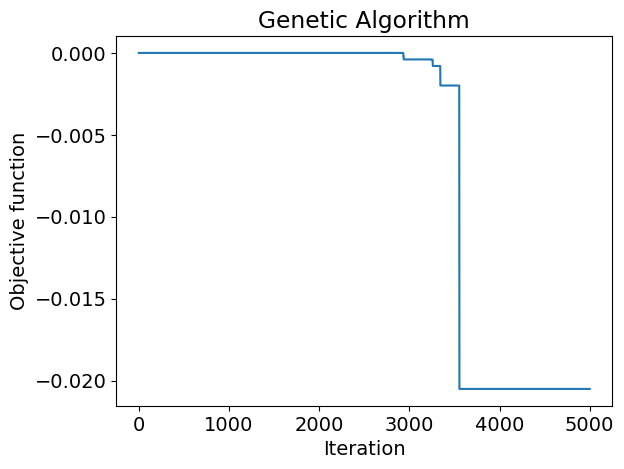

In [149]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [150]:
best_path = gen_alg.output_dict['variable']

In [151]:
best_path_info = pd.DataFrame(columns=['confidence', 'source', 'target'])

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['source_id']==best_path[i]) & (layer['target_id']==best_path[i+1]), ['confidence', 'source', 'target']]
    
        best_path_info = pd.concat([best_path_info.dropna(axis=1, how='all') , path_info], ignore_index=True)

print(best_path_info)

   confidence               source               target
0    0.046921  0_1_2_3_7_8_0_5_1_7  9_0_9_1_7_0_9_4_6_8
1    0.020513  9_0_9_1_7_0_9_4_6_8                    7
2    0.978736                    7                    3


## Visualization

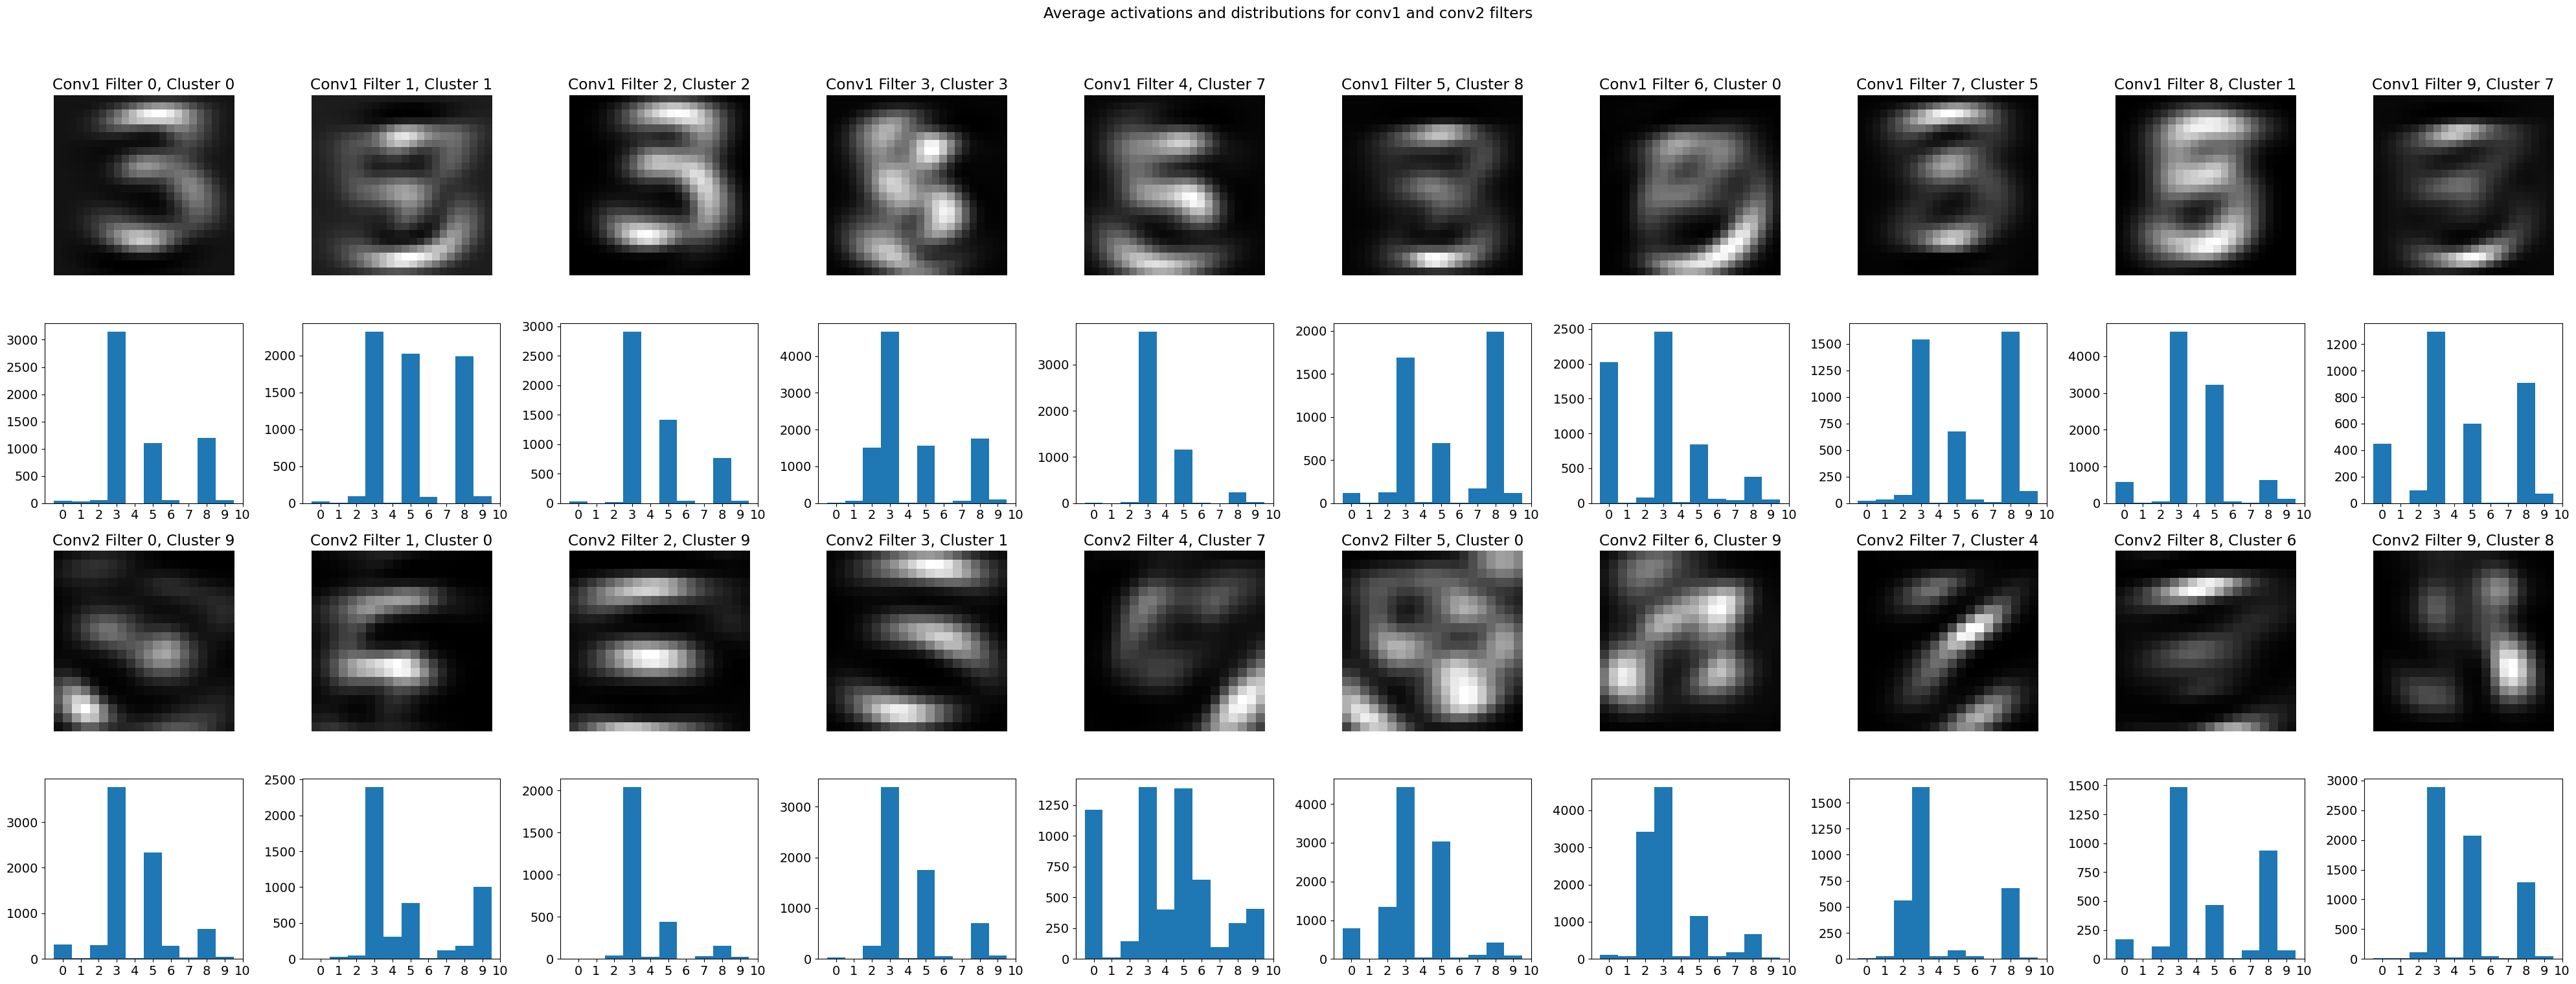

In [152]:
plt.rcParams.update({'font.size': 14})

source_cluster_indexes = best_path_info.loc[0, 'source'].split('_')
target_cluster_indexes = best_path_info.loc[0, 'target'].split('_')

# Determine the maximum number of columns (i.e., filters) for a unified subplot layout
max_filters = max(n_filters_conv_1, n_filters_conv_2)

# # 4 rows: 2 per convolutional layer (one for activation maps, one for cluster histograms)
fig, axes = plt.subplots(4, max_filters, figsize=(max_filters * 4, 16))
fig.suptitle("Average activations and distributions for conv1 and conv2 filters")

# -------------------
# Layer conv1 (layer 0)
# -------------------
for i in range(n_filters_conv_1):
    try:
        source_idx = int(source_cluster_indexes[i])
    except IndexError:
        print(f"Brak indeksu target dla filtra {i}")
        axes[2, i].text(0.5, 0.5, "Missing index", ha='center', va='center')
        axes[2, i].axis('off')
        axes[3, i].axis('off')
        continue

    activation_data = activations[0][artifact_clusters[f'l0_f{i}'] == source_idx, :, :, i]
    cluster_data = artifact_clusters.loc[artifact_clusters[f'l0_f{i}'] == source_idx, :]

    if activation_data.size > 0:
        avg_activation = np.mean(activation_data, axis=0)
        axes[0, i].imshow(avg_activation, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Conv1 Filter {i}, Cluster {source_idx}")

        bins = np.arange(0, 9 + 1.5) - 0.5
        axes[1, i].hist(cluster_data['p'], bins=bins)
        axes[1, i].set_xticks(bins + 0.5)

# -------------------
# Layer conv2 (layer 1)
# -------------------
for i in range(n_filters_conv_2):
    try:
        target_idx = int(target_cluster_indexes[i])
    except IndexError:
        print(f"Brak indeksu target dla filtra {i}")
        axes[2, i].text(0.5, 0.5, "Missing index", ha='center', va='center')
        axes[2, i].axis('off')
        axes[3, i].axis('off')
        continue

    mask = artifact_clusters[f'l1_f{i}'] == target_idx
    num_samples = mask.sum()

    if num_samples > 0:
        activation_data = activations[1][mask, :, :, i]
        avg_activation = np.mean(activation_data, axis=0)

        axes[2, i].imshow(avg_activation, cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Conv2 Filter {i}, Cluster {target_idx}")

        cluster_data = artifact_clusters.loc[mask]
        bins = np.arange(0, 9 + 1.5) - 0.5
        axes[3, i].hist(cluster_data['p'], bins=bins)
        axes[3, i].set_xticks(bins + 0.5)
    else:
        axes[2, i].text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Conv2 Filter {i}, Cluster {target_idx} — brak danych")
        axes[3, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

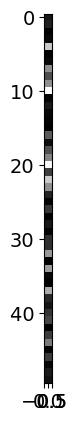

In [153]:
activation_data_3 = activations[3][artifact_clusters[f'l3'] == int(best_path_info.loc[2, 'target']), :]
activation_data_3 = np.mean(activation_data_3, axis=0)
plt.imshow(activation_data_3.reshape(activation_data_3.shape[0], 1, 1), cmap=plt.get_cmap('gray'))